# Model construction and training

In this notebook, we load the data collected previously and use it to train the classifier for rock-paper-scissors.

Since it's necessary also to recognize the "ok" position to start the game, we have decided to create a single model (to facilitate the deployment) with 4 classes to be used in both the preparation and actual game phases.

Libraries

In [12]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import save_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

Dataset loading

In [2]:
#Data regarding the distances between the landmarks
path = "C:\\Users\\fturc\\RPS\\dist_data.csv"
data = pd.read_csv(path, header=None)
data = np.asarray(data)

Labels

In [3]:
z = [0] * int((len(data)/4)) + [1] * int((len(data)/4)) + [2] * int((len(data)/4)) + [3] * int((len(data)/4))
z=np.asarray(z)

Train, test and evaluation split

In [4]:
X_train, X_test_ev, z_train, z_test_ev = train_test_split(data, z, test_size=0.2, random_state=45)
X_val, X_test, z_val, z_test = train_test_split(X_test_ev, z_test_ev, test_size=0.5, random_state=45)

## Model

Mlp model with 4 layers of decreasing size

In [5]:
def model_mlp(num_classes=4, print_summary=False):

    input = tf.keras.layers.Input(len(data[0]), name="input_layer")
    x = tf.keras.layers.Dense(265, activation='relu', input_shape=(len(data[0]),), name="linear_1")(input)
    x = tf.keras.layers.Dense(128, activation='relu', name='linear_2')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name='linear_3')(x)
    
    classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(x)

    model = tf.keras.models.Model(inputs=input, outputs=classification_out, name='model_mlp')

    if print_summary:
        print(model.summary())

    return model

model = model_mlp(print_summary=True)

Model: "model_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 210)]             0         
                                                                 
 linear_1 (Dense)            (None, 265)               55915     
                                                                 
 linear_2 (Dense)            (None, 128)               34048     
                                                                 
 linear_3 (Dense)            (None, 64)                8256      
                                                                 
 class (Dense)               (None, 4)                 260       
                                                                 
Total params: 98,479
Trainable params: 98,479
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [9]:
history = model.fit(X_train, z_train, epochs=30, batch_size=128, validation_data=(X_val, z_val))

test_loss, test_accuracy = model.evaluate(X_test, z_test)
print(f'Accuracy on test: {test_accuracy}')

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/30
10/10 [==============================] - 1s 17ms/step - loss: 0.1033 - accuracy: 0.9695 - val_loss: 0.4004 - val_accuracy: 0.9125
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0846 - accuracy: 0.9734 - val_loss: 0.1014 - val_accuracy: 0.9812
Epoch 3/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0249 - accuracy: 0.9914 - val_loss: 0.1253 - val_accuracy: 0.9688
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0183 - accuracy: 0.9961 - val_loss: 0.0894 - val_accuracy: 0.9750
Epoch 5/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0121 - accuracy: 0.9977 - val_loss: 0.0937 - val_accuracy: 0.9812
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1027 - val_accuracy: 0.9812
Epoch 7/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0909 - val_accuracy: 0.9750
Epoch 8/30
10/10 [=

## Results

In [13]:
def plot_results(tr,val):
    epochs = range(1, len(tr) + 1)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

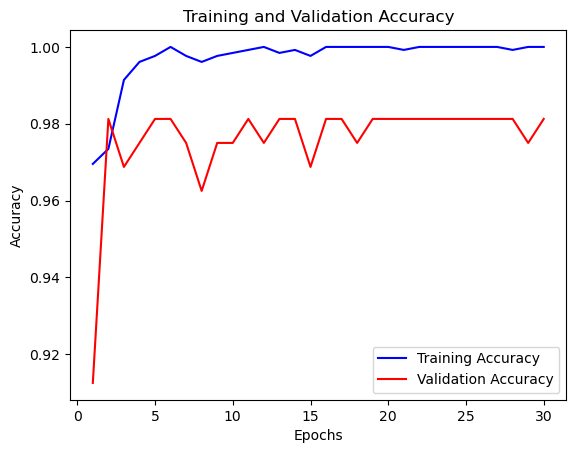

In [14]:
plot_results(train_accuracy, val_accuracy)

In [15]:
pose_map = {
     0: "rock",
     1: "paper",
     2: "scissors",
     3: "ok"
}

In [16]:
def report(X, y_gt):
    #This function takes both the values and the labels for which we want the report as input

    #y_gt is groung truth, y_pm is prediction of the model

    y_pm = model.predict(X)  #Predictions of the test set
    y_pm = np.argmax(y_pm, axis=1) #Get the class

    class_labels = list(pose_map.values())

    print(classification_report(y_gt, y_pm, target_names=class_labels))

In [17]:
#Plot confusion matrix
def plot_confusion_matrix(X, y_gt):
    #This function takes both the values and the labels for which we want the confusion matrix as input

    #y_gt is ground truth, y_pm is the prediction of the model

    y_pm = model.predict(X)  #Predictions of the set
    y_pm = np.argmax(y_pm, axis=1) #Get the class

    y_gt = [pose_map[l] for l in y_gt]  #From number to text
    y_pm = [pose_map[l] for l in y_pm]

    class_labels = list(pose_map.values())

    cm = confusion_matrix(y_gt, y_pm, labels=class_labels, normalize='true')

    cm = np.around(cm, decimals=2)

    print("\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()

    #rotate labels on x axe
    ax = plt.gca()

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(class_labels, rotation=90, ha='center')

    plt.show()

In [19]:
report(X_test, z_test)

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        rock       0.98      1.00      0.99        45
       paper       0.97      1.00      0.99        36
    scissors       1.00      0.95      0.97        37
          ok       0.98      0.98      0.98        42

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



5/5 [==============================] - 0s 1ms/step

Confusion Matrix:


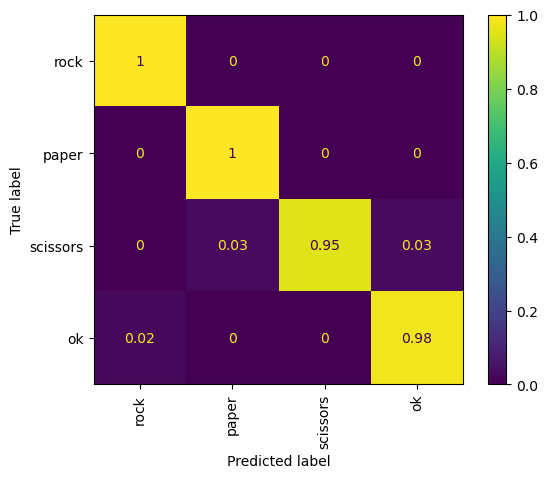

In [20]:
plot_confusion_matrix(X_test, z_test)

Save model

In [ ]:
save_model(model, "C:\\Users\\fturc\\RPS\\RPSmodel.h5")